# Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import linalg
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from math import comb
import random
import time
from sklearn.metrics import mean_squared_error
import copy
from scipy.ndimage import gaussian_filter1d
import os

import scipy.linalg as lin
from scipy.optimize import basinhopping
from scipy.optimize import differential_evolution
from scipy.optimize import brute

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
import wandb


## Functions

In [ ]:
class legendre:
    def __init__(self,theta, dim, dt):
        self.theta = theta
        self.dim = dim
        self.dt = dt
        
        self.P = self.init_P()
        
    def init_P(self):
        window = int(self.theta/self.dt)
        P = np.zeros((window+1,self.dim))
        for t in range(window+1):
            r = t / window
            for i in range(self.dim):
                temp_c = pow((-1),i)
                temp_s = 0
                for j in range(i+1):
                    temp_s = temp_s + comb(i,j) * comb((i+j),j) * pow((-r),j)
             
                P[t,i] = temp_s*temp_c
        return P
    
    def decode(self,M):
        window = int(self.theta/self.dt)
        u = np.zeros(window)
        for t in range(window):
            u[t] = np.sum(np.multiply(self.P[t,:],M))
        return u
    
    def encode(self, u):
        a = np.zeros(self.dim)
        for n in range(self.dim):
            for k in range(int(self.theta/self.dt)):
                a[n] = a[n] + self.P[k,n]*u[k]*self.dt
            a[n] = ( (1/self.theta)*(2*n+1) ) * a[n]
        return a
class cart_pole:
    def __init__(self,g,l,mp,mc,dt):
        self.g = g
        self.l = l
        self.mp = mp
        self.mc = mc
        self.dt = dt
        self.name = '_cart_pole'
    def dynamics(self,x,u):
        x_dot = np.zeros(4)
        x_dot[0] = x[0] + x[1]*self.dt
        
        x_dot[1] = x[1] + ( (u + self.mp * np.sin(x[2]) * (self.l * x[3]**2 - self.g * np.cos(x[2]))) / (self.mc + self.mp * np.sin(x[2])**2) )*(self.dt)
        
        x_dot[2] = x[2] + x[3]*self.dt
        
        x_dot[3] = x[3] + ( (-u*np.cos(x[2]) - self.mp*self.l*x[3]**2 * np.sin(x[2]) * np.cos(x[2]) + (self.mc + self.mp) * self.g * np.sin(x[2])) / (self.l * (self.mc + self.mp * np.sin(x[2])**2)) )*(self.dt)

        return x_dot
def control_traj(N, control_range, sigma):

    min_val, max_val = control_range
    U = np.random.uniform(min_val, max_val, N)
    U_smooth = gaussian_filter1d(U, sigma=sigma, axis=0)
    return U_smooth
    
def state_traj(sys,N,IC,U):
    states = np.zeros((N,4))
    states[0,:] = IC    
    for n in range(1,N):
        u = U[n-1]
        states[n,:] = sys.dynamics(states[n-1,:],u)
    return states
    
def get_time_data(N, var, IC_bounds, num_sims,sigma):
    print("Time data collection. Window: "+str(N) )
    data_u = np.zeros((num_sims,N+4))
    data_x = np.zeros((num_sims,N))
    
    for i in range(num_sims):
        #if i%int(num_sims/10) == 0:
        #    print(str(i)+"/"+str(num_sims))
        IC = np.random.uniform(IC_bounds[0],IC_bounds[1],4)
        U = control_traj(N,var,sigma)
        X = state_traj(sys,N,IC,U)[:,2]  #Where is this system value coming from???!
        
        data_u[i,:] = np.append(IC,U)
        data_x[i,:] = X
    np.savetxt('time_u_'+str(N)+sys.name, data_u)    
    np.savetxt('time_x_'+str(N)+sys.name, data_x)
    return data_u,data_x
    
def get_leg_data(data_u,data_x,leg_order,dt):
    print("Legendre order " + str(leg_order) + " data collection")
    num_sims,N = data_x.shape 
    
    data_u_m = np.zeros((num_sims,leg_order+4))
    data_x_m = np.zeros((num_sims,leg_order))
    leg = legendre(N*dt,leg_order,dt)

    for i in range(num_sims):
        #if i%int(num_sims/10) == 0:
        #    print(str(i)+"/"+str(num_sims))
        U = data_u[i,4:N+4]
        X = data_x[i,:]
        IC = data_u[i,0:4]
        U_m = leg.encode(U)
        X_m = leg.encode(X)

        data_u_m[i,:] = np.append(IC,U_m)
        data_x_m[i,:] = X_m
    np.savetxt('leg_u_'+str(N)+'_'+str(leg_order)+sys.name, data_u_m)    
    np.savetxt('leg_x_'+str(N)+'_'+str(leg_order)+sys.name, data_x_m)    
    return data_u_m,data_x_m

# Training and Testing

## Fixed Middle Layer

In [ ]:
num_trials = 5
new_dir = input("Enter the name of the directory to save plots and data: ")
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
    
wandb.login()

#Define system
g = 9.8 #gravity
l = 0.05 #length
dt = 0.001 #sampling time
mp = 0.001 #pole mass
mc = 0.01 #cart mass
sys = cart_pole(g,l,mp,mc,dt)

#Data collection
#N = [3,5,10,15,20,25,30,35,40,45,50,150]
#N = [200]
#N = [20,40,60,80,100,120,140,160,180,200,220,240,260,280,300]
N =[50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]
control_bounds = [-1,1]
IC_bounds = [-10,10]
num_sims = 100000
sigma = 2
leg_order = [5,10,15,20]

N_data_filename = os.path.join(new_dir, 'N_data.txt')
np.savetxt(N_data_filename, N, fmt='%.5f')

Leg_data_filename = os.path.join(new_dir, 'Leg_data.txt')
np.savetxt(Leg_data_filename, leg_order, fmt='%.5f')

for n in N:
    if not os.path.exists('time_u_'+str(n)+sys.name):
        data_u,data_x = get_time_data(n, control_bounds, IC_bounds, num_sims,sigma)
    else:
        data_u = np.loadtxt('time_u_'+str(n)+sys.name)
        data_x = np.loadtxt('time_x_'+str(n)+sys.name)
        print(f'Time File Exists - N: {n}')
    for order in leg_order: 
        if not os.path.exists('leg_u_'+str(n)+'_'+str(order)+sys.name):    
            data_u_m, data_x_m = get_leg_data(data_u,data_x,order,dt)
        else:
            print(f'Legendre File Exists - N: {n}, Order: {order}')
    '''
    for n in N:
        data_u,data_x = get_time_data(n, control_bounds, IC_bounds, num_sims,sigma)
        for order in leg_order: 
                data_u_m, data_x_m = get_leg_data(data_u,data_x,order,dt)
    '''        
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size, middle_layer):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, middle_layer)
        self.layer2 = nn.Linear(middle_layer, output_size)
        #self.layer2 = nn.Linear(128, 64)
        #self.layer3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        #x = self.relu(self.layer2(x))
        #x = self.layer3(x)
        return x
    
batch_size = 32

train_size = 0.7
val_size = 0.15
test_size = 0.15
num_epochs = 20
middle_layer = 128

criterion = nn.MSELoss()


for trial in range(num_trials):
    print(f'Trial Number: {trial+1} out of {num_trials}')
    test_loss_data_time = np.zeros(len(N))
    iter = 0
    for n in N:
        wandb.init(project=f"nn-training-constant-middlelayer-trial-{trial}", name=f"training-N-{n}", config={"parameter_N": n})
    
        data_u = np.loadtxt("time_u_"+str(n)+sys.name)
        data_x = np.loadtxt("time_x_"+str(n)+sys.name)
        
        num_samples=data_x.shape[0]
        
        train_range = [0,int(train_size*num_samples)]
        val_range = [int(train_size*num_samples),int((train_size+val_size)*num_samples)]
        test_range = [int((train_size+val_size)*num_samples),num_samples]
    
        inputs = torch.tensor(data_u, dtype=torch.float32)
        outputs = torch.tensor(data_x,dtype=torch.float32)
        dataset = TensorDataset(inputs, outputs)
        
        train_data = Subset(dataset, range(train_range[0],train_range[1]))
        val_data = Subset(dataset, range(val_range[0],val_range[1]))
        test_data = Subset(dataset, range(test_range[0],test_range[1]))
    
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
        model = SimpleNN(input_size=n+4, output_size=n,middle_layer = middle_layer )
        total_params = sum(p.numel() for p in model.parameters())
    
        print(f'Input Layer: {n+4}, Middle Layer: {middle_layer}, Output Layer: {n} ')
        print(f'Total Parameters: {total_params}')
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Using device: {device}')
        model = model.to(device)
    
        print(f'Time window: {n}')
        
        
        for epoch in range(num_epochs):
            avg_loss=0
            val_loss = 0
            model.train()
            for batch_inputs, batch_outputs in train_loader:
                batch_inputs, batch_outputs = batch_inputs.to(device), batch_outputs.to(device)
                optimizer.zero_grad()
                predictions = model(batch_inputs)
                loss = criterion(predictions, batch_outputs)
                loss.backward()
                optimizer.step()
                avg_loss+=loss/len(train_loader)
            wandb.log({"loss": avg_loss})
            #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
            
            model.eval()
            for batch_inputs, batch_outputs in val_loader:
                batch_inputs, batch_outputs = batch_inputs.to(device), batch_outputs.to(device)
                predictions = model(batch_inputs)
                loss = criterion(predictions,batch_outputs)
                val_loss += loss.item()/len(test_loader)
            wandb.log({"validation loss": val_loss})
            #print(f'Validation loss: {val_loss:.4f}')
            
        test_loss = 0
        model.eval()
        with torch.no_grad():
            for batch_inputs,batch_outputs in test_loader:
                batch_inputs, batch_outputs = batch_inputs.to(device), batch_outputs.to(device)
                predictions = model(batch_inputs)
                loss = criterion(predictions,batch_outputs)
                test_loss += loss.item()/len(test_loader)
        print(f'Test loss: {test_loss:.4f}')
        test_loss_data_time[iter] = test_loss
        iter+=1
    
    criterion = nn.MSELoss()
    
    test_loss_data_leg = np.zeros((len(leg_order),len(N)))
    time_loss_data_leg = np.zeros((len(leg_order),len(N)))
    
    iter_n = 0
    
    for n in N:
        iter_order = 0
        
        for order in leg_order:
            wandb.init(project=f"nn-training-constant-para-trial-{trial}", name=f"training-N-{n}-Order-{order}", config={"parameter_N": n})
            leg = legendre(n*dt,order,dt)
            
            data_u = np.loadtxt("leg_u_"+str(n)+"_"+str(order)+sys.name)
            data_x = np.loadtxt("leg_x_"+str(n)+"_"+str(order)+sys.name)
            time_data_x = np.loadtxt("time_x_"+str(n)+sys.name)
    
            num_samples=data_x.shape[0]
            
            train_range = [0,int(train_size*num_samples)]
            val_range = [int(train_size*num_samples),int((train_size+val_size)*num_samples)]
            test_range = [int((train_size+val_size)*num_samples),num_samples]
            
            inputs = torch.tensor(data_u, dtype=torch.float32)
            outputs = torch.tensor(data_x,dtype=torch.float32)
            time_outputs = torch.tensor(time_data_x,dtype=torch.float32)
            dataset = TensorDataset(inputs, outputs,time_outputs)
            
            train_data = Subset(dataset, range(train_range[0],train_range[1]))
            val_data = Subset(dataset, range(val_range[0],val_range[1]))
            test_data = Subset(dataset, range(test_range[0],test_range[1]))
            
            train_data,val_data,test_data = random_split(dataset,[int(train_size*num_samples),int(val_size*num_samples),int(test_size*num_samples)])
            
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
            val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
            
            model = SimpleNN(input_size=order+4, output_size=order, middle_layer = middle_layer )
            print(f'Input Layer: {order+4}, Middle Layer: {middle_layer}, Output Layer: {order} ')
            total_params = sum(p.numel() for p in model.parameters())
            print(f'Total Parameters: {total_params}')
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            print(f'Using device: {device}')
            model = model.to(device)
        
            print(f'Time window: {n}, Order: {order}')
            
           
            for epoch in range(num_epochs):
                avg_loss=0
                val_loss = 0
                model.train()
                for batch_inputs, batch_outputs, time_outputs in train_loader:
                    batch_inputs, batch_outputs = batch_inputs.to(device), batch_outputs.to(device)
                    optimizer.zero_grad()
                    predictions = model(batch_inputs)
                    loss = criterion(predictions, batch_outputs)
                    loss.backward()
                    optimizer.step()
                    avg_loss+=loss/len(train_loader)
                wandb.log({"loss": avg_loss})
                #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
    
                model.eval()
                for batch_inputs, batch_outputs, time_outputs in val_loader:
                    batch_inputs, batch_outputs = batch_inputs.to(device), batch_outputs.to(device)
                    predictions = model(batch_inputs)
                    loss = criterion(predictions,batch_outputs)
                    val_loss += loss.item()/len(test_loader)
                #print(f'Validation loss: {val_loss:.4f}')
                wandb.log({"validation loss": val_loss})
    
                
            test_loss = 0
            time_test_loss = 0
            model.eval()
            with torch.no_grad():
                for batch_inputs,batch_outputs,time_outputs in test_loader:
                    batch_inputs, batch_outputs, time_outputs = batch_inputs.to(device), batch_outputs.to(device), time_outputs.to(device)
                    predictions = model(batch_inputs)
                    loss = criterion(predictions,batch_outputs)
                    test_loss += loss.item()/len(test_loader)
                    time_test_loss += time_leg_eval(leg,predictions,time_outputs,device,criterion)/len(test_loader)
            
            print(f'Test loss: {test_loss:.4f}')
            print(f'Loss between leg-traj and time-traj: {time_test_loss:.4f}')
            #test_loss_data[iter] = test_loss
            test_loss_data_leg[iter_order,iter_n] = test_loss
            time_loss_data_leg[iter_order,iter_n] = time_test_loss
            iter_order+=1
            #plot_intermediete_model(predictions,batch_outputs,time_outputs)
        iter_n+=1
    
    wandb.finish()
    plt.figure(figsize=(12, 6))
    for i, order in enumerate(leg_order):
        plt.plot(N, time_loss_data_leg[i,:], label=f'Order {order}')
    plt.plot(N,test_loss_data_time, label = f'Time')
    plt.xlabel('Window Length (N)')
    plt.ylabel('RMS')
    plt.title('Loss Data')
    plt.legend()
    plt.grid(True)
    
    save_data = np.vstack((test_loss_data_time,time_loss_data_leg))
    RMSE_data_filename = os.path.join(new_dir, f'RMSE_data_{trial+1}.txt')
    np.savetxt(RMSE_data_filename, save_data, fmt='%.5f')
    
    plot_filename = os.path.join(new_dir, f'RMSE_Window_{trial+1}.png')
    plt.savefig(plot_filename)
    plt.show()
    plt.close()


# Load data and do the plotting
plt.figure(figsize=(12, 6))
data = np.zeros((num_trials,len(leg_order)+1,len(N)))
for trial in range(num_trials):
    RMSE_data_filename = os.path.join(new_dir, f'RMSE_data_{trial+1}.txt')
    data[trial,:,:] = np.loadtxt(RMSE_data_filename)
data = np.where(data > 200, np.nan, data)

plot_data_mean = np.zeros((len(leg_order)+1,len(N)))
plot_data_std = np.zeros((len(leg_order)+1,len(N)))
for order_n in range(len(leg_order)+1):
    plot_data_mean[order_n,:] = np.nanmean(data[:,order_n,:], axis=0)
    plot_data_std[order_n,:] = np.nanstd(data[:,order_n,:], axis=0)
    if order_n == 0:
        plot_label = 'Time'
    else:
        plot_label = f'Order: {leg_order[order_n-1]}'
    plt.plot(N, plot_data_mean[order_n,:], label=plot_label)
    plt.fill_between(N, plot_data_mean[order_n,:] - plot_data_std[order_n,:], plot_data_mean[order_n,:] + plot_data_std[order_n,:], alpha=0.2)
#plt.yscale('log')
plt.ylim([0.0,175])
plt.title(f'RMSE over Window Length, Mean and STD of {num_trials} Trials\nFixed Middle Layer: {middle_layer}')
plt.xlabel('Window Length')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plot_filename = os.path.join(new_dir, f'RMSE_Window_Mean_STD.png')

plt.savefig(plot_filename)
plt.show()
plt.close()

## Constant Parameters

In [ ]:
num_trials = 5
new_dir = input("Enter the name of the directory to save plots and data: ")
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
    
wandb.login()

#Define system
g = 9.8 #gravity
l = 0.05 #length
dt = 0.001 #sampling time
mp = 0.001 #pole mass
mc = 0.01 #cart mass
sys = cart_pole(g,l,mp,mc,dt)

#Data collection
#N = [3,5,10,15,20,25,30,35,40,45,50,150]
#N = [200]
#N = [20,40,60,80,100,120,140,160,180,200,220,240,260,280,300]
N =[50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]
control_bounds = [-1,1]
IC_bounds = [-10,10]
num_sims = 100000
sigma = 2
leg_order = [5,10,15,20]

N_data_filename = os.path.join(new_dir, 'N_data.txt')
np.savetxt(N_data_filename, N, fmt='%.5f')

Leg_data_filename = os.path.join(new_dir, 'Leg_data.txt')
np.savetxt(Leg_data_filename, leg_order, fmt='%.5f')

for n in N:
    if not os.path.exists('time_u_'+str(n)+sys.name):
        data_u,data_x = get_time_data(n, control_bounds, IC_bounds, num_sims,sigma)
    else:
        data_u = np.loadtxt('time_u_'+str(n)+sys.name)
        data_x = np.loadtxt('time_x_'+str(n)+sys.name)
        print(f'Time File Exists - N: {n}')
    for order in leg_order: 
        if not os.path.exists('leg_u_'+str(n)+'_'+str(order)+sys.name):    
            data_u_m, data_x_m = get_leg_data(data_u,data_x,order,dt)
        else:
            print(f'Legendre File Exists - N: {n}, Order: {order}')
    '''
for n in N:
    data_u,data_x = get_time_data(n, control_bounds, IC_bounds, num_sims,sigma)
    for order in leg_order: 
            data_u_m, data_x_m = get_leg_data(data_u,data_x,order,dt)
'''      
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size, middle_layer):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, middle_layer)
        self.layer2 = nn.Linear(middle_layer, output_size)
        #self.layer2 = nn.Linear(128, 64)
        #self.layer3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        #x = self.relu(self.layer2(x))
        #x = self.layer3(x)
        return x
    
batch_size = 32

train_size = 0.7
val_size = 0.15
test_size = 0.15
num_epochs = 20
total_param = 10000

criterion = nn.MSELoss()


for trial in range(num_trials):
    print(f'Trial Number: {trial+1} out of {num_trials}')
    test_loss_data_time = np.zeros(len(N))
    iter = 0
    for n in N:
        wandb.init(project=f"nn-training-constant-para-trial-{trial}", name=f"training-N-{n}", config={"parameter_N": n})
    
        data_u = np.loadtxt("time_u_"+str(n)+sys.name)
        data_x = np.loadtxt("time_x_"+str(n)+sys.name)
        
        num_samples=data_x.shape[0]
        
        train_range = [0,int(train_size*num_samples)]
        val_range = [int(train_size*num_samples),int((train_size+val_size)*num_samples)]
        test_range = [int((train_size+val_size)*num_samples),num_samples]
    
        inputs = torch.tensor(data_u, dtype=torch.float32)
        outputs = torch.tensor(data_x,dtype=torch.float32)
        dataset = TensorDataset(inputs, outputs)
        
        train_data = Subset(dataset, range(train_range[0],train_range[1]))
        val_data = Subset(dataset, range(val_range[0],val_range[1]))
        test_data = Subset(dataset, range(test_range[0],test_range[1]))
    
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
        middle_layer = int(np.round(total_param / (2*n+4)))
        model = SimpleNN(input_size=n+4, output_size=n,middle_layer = middle_layer )
        total_params = sum(p.numel() for p in model.parameters())
    
        print(f'Input Layer: {n+4}, Middle Layer: {middle_layer}, Output Layer: {n} ')
        print(f'Total Parameters: {total_params}')
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Using device: {device}')
        model = model.to(device)
    
        print(f'Time window: {n}')
        
        
        for epoch in range(num_epochs):
            avg_loss=0
            val_loss = 0
            model.train()
            for batch_inputs, batch_outputs in train_loader:
                batch_inputs, batch_outputs = batch_inputs.to(device), batch_outputs.to(device)
                optimizer.zero_grad()
                predictions = model(batch_inputs)
                loss = criterion(predictions, batch_outputs)
                loss.backward()
                optimizer.step()
                avg_loss+=loss/len(train_loader)
            wandb.log({"loss": avg_loss})
            #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
            
            model.eval()
            for batch_inputs, batch_outputs in val_loader:
                batch_inputs, batch_outputs = batch_inputs.to(device), batch_outputs.to(device)
                predictions = model(batch_inputs)
                loss = criterion(predictions,batch_outputs)
                val_loss += loss.item()/len(test_loader)
            wandb.log({"validation loss": val_loss})
            #print(f'Validation loss: {val_loss:.4f}')
            
        test_loss = 0
        model.eval()
        with torch.no_grad():
            for batch_inputs,batch_outputs in test_loader:
                batch_inputs, batch_outputs = batch_inputs.to(device), batch_outputs.to(device)
                predictions = model(batch_inputs)
                loss = criterion(predictions,batch_outputs)
                test_loss += loss.item()/len(test_loader)
        print(f'Test loss: {test_loss:.4f}')
        test_loss_data_time[iter] = test_loss
        iter+=1
    
    criterion = nn.MSELoss()
    
    test_loss_data_leg = np.zeros((len(leg_order),len(N)))
    time_loss_data_leg = np.zeros((len(leg_order),len(N)))
    
    iter_n = 0
    
    for n in N:
        iter_order = 0
        
        for order in leg_order:
            wandb.init(project=f"nn-training-constant-para-trial-{trial}", name=f"training-N-{n}-Order-{order}", config={"parameter_N": n})
            leg = legendre(n*dt,order,dt)
            
            data_u = np.loadtxt("leg_u_"+str(n)+"_"+str(order)+sys.name)
            data_x = np.loadtxt("leg_x_"+str(n)+"_"+str(order)+sys.name)
            time_data_x = np.loadtxt("time_x_"+str(n)+sys.name)
    
            num_samples=data_x.shape[0]
            
            train_range = [0,int(train_size*num_samples)]
            val_range = [int(train_size*num_samples),int((train_size+val_size)*num_samples)]
            test_range = [int((train_size+val_size)*num_samples),num_samples]
            
            inputs = torch.tensor(data_u, dtype=torch.float32)
            outputs = torch.tensor(data_x,dtype=torch.float32)
            time_outputs = torch.tensor(time_data_x,dtype=torch.float32)
            dataset = TensorDataset(inputs, outputs,time_outputs)
            
            train_data = Subset(dataset, range(train_range[0],train_range[1]))
            val_data = Subset(dataset, range(val_range[0],val_range[1]))
            test_data = Subset(dataset, range(test_range[0],test_range[1]))
            
            train_data,val_data,test_data = random_split(dataset,[int(train_size*num_samples),int(val_size*num_samples),int(test_size*num_samples)])
            
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
            val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
            
            middle_layer = int(np.round(total_param / (2*order+4)))
            model = SimpleNN(input_size=order+4, output_size=order, middle_layer = middle_layer )
            print(f'Input Layer: {order+4}, Middle Layer: {middle_layer}, Output Layer: {order} ')
            total_params = sum(p.numel() for p in model.parameters())
            print(f'Total Parameters: {total_params}')
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            print(f'Using device: {device}')
            model = model.to(device)
        
            print(f'Time window: {n}, Order: {order}')
            
           
            for epoch in range(num_epochs):
                avg_loss=0
                val_loss = 0
                model.train()
                for batch_inputs, batch_outputs, time_outputs in train_loader:
                    batch_inputs, batch_outputs = batch_inputs.to(device), batch_outputs.to(device)
                    optimizer.zero_grad()
                    predictions = model(batch_inputs)
                    loss = criterion(predictions, batch_outputs)
                    loss.backward()
                    optimizer.step()
                    avg_loss+=loss/len(train_loader)
                wandb.log({"loss": avg_loss})
                #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
    
                model.eval()
                for batch_inputs, batch_outputs, time_outputs in val_loader:
                    batch_inputs, batch_outputs = batch_inputs.to(device), batch_outputs.to(device)
                    predictions = model(batch_inputs)
                    loss = criterion(predictions,batch_outputs)
                    val_loss += loss.item()/len(test_loader)
                #print(f'Validation loss: {val_loss:.4f}')
                wandb.log({"validation loss": val_loss})
    
                
            test_loss = 0
            time_test_loss = 0
            model.eval()
            with torch.no_grad():
                for batch_inputs,batch_outputs,time_outputs in test_loader:
                    batch_inputs, batch_outputs, time_outputs = batch_inputs.to(device), batch_outputs.to(device), time_outputs.to(device)
                    predictions = model(batch_inputs)
                    loss = criterion(predictions,batch_outputs)
                    test_loss += loss.item()/len(test_loader)
                    time_test_loss += time_leg_eval(leg,predictions,time_outputs,device,criterion)/len(test_loader)
            
            print(f'Test loss: {test_loss:.4f}')
            print(f'Loss between leg-traj and time-traj: {time_test_loss:.4f}')
            #test_loss_data[iter] = test_loss
            test_loss_data_leg[iter_order,iter_n] = test_loss
            time_loss_data_leg[iter_order,iter_n] = time_test_loss
            iter_order+=1
            #plot_intermediete_model(predictions,batch_outputs,time_outputs)
        iter_n+=1
    
    wandb.finish()
    plt.figure(figsize=(12, 6))
    for i, order in enumerate(leg_order):
        plt.plot(N, time_loss_data_leg[i,:], label=f'Order {order}')
    plt.plot(N,test_loss_data_time, label = f'Time')
    plt.xlabel('Window Length (N)')
    plt.ylabel('RMS')
    plt.title('Loss Data')
    plt.legend()
    plt.grid(True)
    
    save_data = np.vstack((test_loss_data_time,time_loss_data_leg))
    RMSE_data_filename = os.path.join(new_dir, f'RMSE_data_{trial+1}.txt')
    np.savetxt(RMSE_data_filename, save_data, fmt='%.5f')
    
    plot_filename = os.path.join(new_dir, f'RMSE_Window_{trial+1}.png')
    plt.savefig(plot_filename)
    plt.show()
    plt.close()


# Load data and do the plotting
plt.figure(figsize=(12, 6))
data = np.zeros((num_trials,len(leg_order)+1,len(N)))
for trial in range(num_trials):
    RMSE_data_filename = os.path.join(new_dir, f'RMSE_data_{trial+1}.txt')
    data[trial,:,:] = np.loadtxt(RMSE_data_filename)
data = np.where(data > 200, np.nan, data)

plot_data_mean = np.zeros((len(leg_order)+1,len(N)))
plot_data_std = np.zeros((len(leg_order)+1,len(N)))
for order_n in range(len(leg_order)+1):
    plot_data_mean[order_n,:] = np.nanmean(data[:,order_n,:], axis=0)
    plot_data_std[order_n,:] = np.nanstd(data[:,order_n,:], axis=0)
    if order_n == 0:
        plot_label = 'Time'
    else:
        plot_label = f'Order: {leg_order[order_n-1]}'
    plt.plot(N, plot_data_mean[order_n,:], label=plot_label)
    plt.fill_between(N, plot_data_mean[order_n,:] - plot_data_std[order_n,:], plot_data_mean[order_n,:] + plot_data_std[order_n,:], alpha=0.2)
#plt.yscale('log')
plt.ylim([0.0,175])
plt.title(f'RMSE over Window Length, Mean and STD of {num_trials} Trials')
plt.xlabel('Window Length')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plot_filename = os.path.join(new_dir, f'RMSE_Window_Mean_STD.png')

plt.savefig(plot_filename)
plt.show()
plt.close()

# Plotting

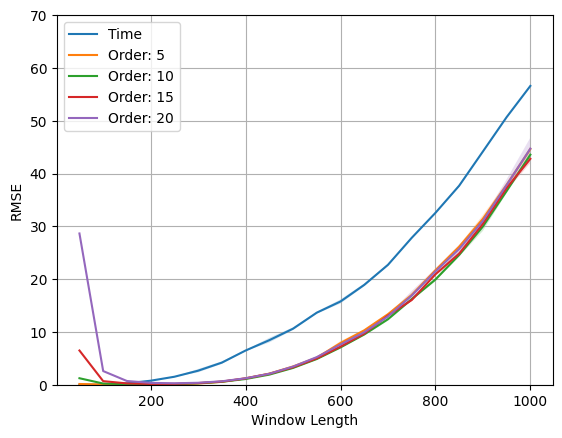

In [8]:
#Define directory
#directory = 'cartpole_constant_middlelayer_5_trials_run'
directory = ('cartpole_constant_para_5_trials_run')
title = f'Mean RMSE over Window Length, {5} Trials, Constant Middle Layer: 128'


# Load data and do the plotting
#plt.figure(figsize=(12, 6))
num_trials = 5
N = np.loadtxt(f'{directory}/N_data.txt')
leg_order = np.loadtxt(f'{directory}/Leg_data.txt')
data = np.zeros((num_trials,len(leg_order)+1,len(N)))
for trial in range(num_trials):
    RMSE_data_filename = os.path.join(directory, f'RMSE_data_{trial+1}.txt')
    data[trial,:,:] = np.loadtxt(RMSE_data_filename)
data = np.where(data > 200, np.nan, data)

plot_data_mean = np.zeros((len(leg_order)+1,len(N)))
plot_data_std = np.zeros((len(leg_order)+1,len(N)))
for order_n in range(len(leg_order)+1):
    plot_data_mean[order_n,:] = np.nanmean(data[:,order_n,:], axis=0)
    plot_data_std[order_n,:] = np.nanstd(data[:,order_n,:], axis=0)
    if order_n == 0:
        plot_label = 'Time'
    else:
        plot_label = f'Order: {int(leg_order[order_n-1])}'
    plt.plot(N, plot_data_mean[order_n,:], label=plot_label)
    plt.fill_between(N, plot_data_mean[order_n,:] - plot_data_std[order_n,:], plot_data_mean[order_n,:] + plot_data_std[order_n,:], alpha=0.2)
#plt.yscale('log')
plt.ylim([0.0,175])
#plt.title(title)
plt.xlabel('Window Length')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.ylim([0,70])
plt.savefig('NN_sysID_constPara.png')